In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [2]:
def computeFS(fs, production, r_tax, r_debt, w_pay, t0_i, n_collec_per):
    '''
    Calculates the balance sheet and income statement, in place, based
    on the balance sheet at time "Zero" indicated by t0_i, sales 
    projections, production weights, tax rate, debt cost, etc, as
    shown below.
    
    fs -->  A (16,n) array consisting of past, present, and expected
            financial performance. Forecasted net sales and n_collec_per
            worth of previous sales numbers must be pre-populated in fs.
            In addition, COGS, OpEx, Net PPE, and LT Debt, CP must be
            included within the forecast window. Lastly, the complete
            balance sheet from one period prior to t0 must be included.
            
            Below is the row index dictionary, indicies 0-5 correspond
            to the income statement and 6-16 are the balance sheet:
            
            00: Net Sales
            01: Cost of Goods Sold
            02: Operating Expenses
            03: Earnings Before Interest and Taxes
            04: Taxes
            05: Net Profit
            06: Cash
            07: Accounts Receivable
            08: Inventory
            09: Net Plant, Property, and Equipment
            10: Accounts Payable
            11: Notes Payable
            12: Accured Taxes
            13: Long-term Debt, Current Portion
            14: Long-term Debt
            15: Shareholder's Equity
            
    production -->  The production schedule for the firm in terms
                    of the amount of COGS made per month
                    
    r_tax -->  Corporate tax rate of the firm
    
    r_debt --> Cost of debt for the firm
    
    w_pay -->  Monthly balance of accounts payable as a fraction of
               net sales
               
    t0_i -->   Index within fs at which the financial analysis starts
    
    n_collec_per --> Average number of periods that it takes to collect
                     sales since they were added to accounts receivable
    
    '''
    for i in range(t0_i, fs.shape[1]):
        #Calculate IS values        
        #Calculate EBIT
        fs[3,i] = fs[0,i] - fs[1,i] - fs[2,i]
        
        #Calculate taxes
        fs[4,i] = r_tax*(fs[3,i] - fs[11,i-1]*r_debt)
        
        #Calculate net profit
        fs[5,i] = fs[3,i] - fs[11,i-1]*r_debt - fs[4,i]
        
        #Calculate BS values
        #Calculate new value of accounts receivables
        fs[7,i] = fs[7,i-1] - fs[0,i-n_collec_per] + fs[0,i]
        
        #Calculate new inventory level
        fs[8,i] = fs[8,i-1] + production[i-t0_i] - fs[1,i]
        
        #Calculate PPE
        fs[9,i] = fs[9,i-1]
        
        #Calculate new accounts payable
        fs[10,i] = w_pay*fs[0,i]
        
        #Calculate new accrued taxes
        fs[12,i] = fs[12,i-1] + fs[4,i]
        
        #Pay taxes if it is March
        if (i-t0_i+1) % 12 == 3:
            #Pay accured taxes as of Dec year end
            fs[12,i] -= fs[12,i-3]
            
        #Pay esitmate of current years taxes if April, June, Sept, or Dec
        if (i-t0_i+1) % 12 in [4,9]:
            fs[12,i] -= 31
        elif (i-t0_i+1) % 12 in [6,12]:
            fs[12,i] -= 32
        
        #Calculate current portion of long-term debt
        fs[13,i] = fs[13,i-1]
        
        #Calculate long-term debt, $25 payments in June and Dec
        fs[14,i] = fs[14,i-1]
        if (i-t0_i+1 == 6) or (i-t0_i+1 == 12):
            fs[14,i] -= 25
        
        #Calculate share holder's equity
        fs[15,i] = fs[15,i-1] + fs[5,i]
        
        #Calculate cash
        fs[6,i] = fs[6,i-1] - \
                  (fs[7,i] - fs[7,i-1]) - \
                  (fs[8,i] - fs[8,i-1]) - \
                  (fs[9,i] - fs[9,i-1]) + \
                  (fs[10,i] - fs[10,i-1]) + \
                  (fs[12,i] - fs[12,i-1]) + \
                  (fs[15,i] - fs[15,i-1])
                
        #Calculate notes payable payment
        if fs[6,i] > 175.0:
            fs[11,i] = max( 0, fs[11,i-1] - (fs[6,i] - 175) )
            fs[6,i] += fs[11,i] - fs[11,i-1]
        else:
            fs[6,i] = 175
            fs[11,i] = (fs[6,i] + fs[7,i] + fs[8,i] + fs[9,1]) - \
                       (fs[10,i] + fs[12,i] + fs[13,i] + fs[14,i] + fs[15,i])
        

In [3]:
dec1990BS = [175.,2628.,530.,1070.,255.,680.,80.,50.,400.,2938.]
prevSales = [1778., 850.]
projectedSales = [108.,126.,145.,125.,125.,125.,145.,1458.,1655.,1925.,2057.,1006.]
cogsPercent = 0.6516
totalProduction = cogsPercent*np.sum(projectedSales)
operatingExpenses = 196
netPPE = 1070
currentLTD = 50
r_debt = 0.11/12
r_tax = 0.34
r_payables = 0.3
n_per_collect_AR = 2
t0 = 2

finStatements = np.zeros((16,14))
finStatements[0] = prevSales + projectedSales
finStatements[6:,1] = dec1990BS
finStatements[1] = cogsPercent*finStatements[0]
finStatements[2] = operatingExpenses
finStatements[9] = netPPE
finStatements[13] = currentLTD

In [4]:
numTrials = 10000

#Save net profit, max notes payable, and production weights
results = np.empty((14,numTrials))
results[2:,:] = np.random.rand(12,numTrials)
results[2:,:] /= np.sum(results[2:,:], 0)

#Create array of financial statements
trials = np.empty((16,14,numTrials))

for i in range(numTrials):
    trials[:,:,i] = finStatements
    computeFS(trials[:,:,i], results[2:,i]*totalProduction, r_tax, r_debt, r_payables, t0, n_per_collect_AR)
    results[0,i] = trials[5,t0:,i].sum()
    results[1,i] = trials[11,t0:,i].max()

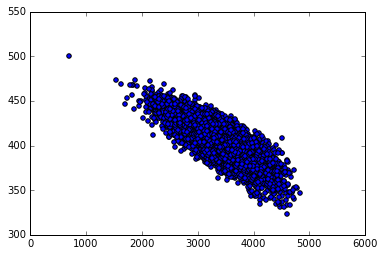

In [5]:
plt.scatter(results[1], results[0])